<a href="https://colab.research.google.com/github/alexuqt/neural-networks/blob/main/0_prova.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install snntorch # shift + enter

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 2.6 MB/s eta 0:00:00


In [ ]:
# imports
import snntorch as snn
from snntorch import spikeplot as splt
import torch

# plotting
import matplotlib.pyplot as plt
from IPython.display import HTML


import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import itertools


dtype = torch.long
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [ ]:
def measure_accuracy(model, dataloader):
  with torch.no_grad():
    model.eval()
    running_length = 0
    running_accuracy = 0

    for data, targets in iter(dataloader):
      data = data.to(device)
      targets = targets.to(device)

      # forward-pass
      spk_rec, _ = model(data)
      spike_count = spk_rec.sum(0) # batch x num_outputs
      _, max_spike = spike_count.max(1)

      # correct classes for one batch
      num_correct = (max_spike == targets).sum()

      # total accuracy
      running_length += len(targets)
      running_accuracy += num_correct

    accuracy = (running_accuracy / running_length)

    return accuracy.item()

In [ ]:
!pip install tonic --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.7/112.7 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 5.1 MB/s eta 0:00:00


  0%|          | 0/700096 [00:00<?, ?it/s]

Extracting ./data/POKERDVS/pips_train.tar.gz to ./data/POKERDVS


  0%|          | 0/311022 [00:00<?, ?it/s]

Extracting ./data/POKERDVS/pips_test.tar.gz to ./data/POKERDVS
[(    0, 27, 13, 0) (   39,  5, 22, 1) (   69, 22, 12, 0) ...
 (13560, 20, 13, 0) (13572, 10, 17, 1) (13572, 10,  6, 1)]


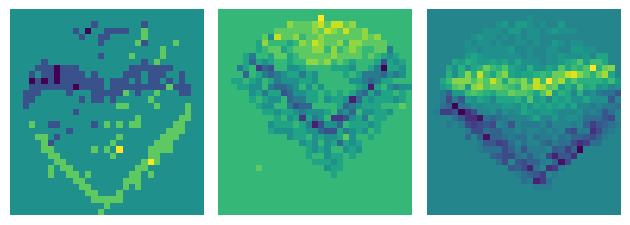

In [ ]:
import tonic

dataset = tonic.datasets.POKERDVS(save_to='./data', train=True)
testset = tonic.datasets.POKERDVS(save_to='./data', train=False)

events, target = dataset[0]
print(events)
tonic.utils.plot_event_grid(events)


In [ ]:
tonic.datasets.POKERDVS.sensor_size

(35, 35, 2)

In [ ]:
import torchvision
from tonic import DiskCachedDataset
from torch.utils.data import DataLoader

# time_window
frame_transform = tonic.transforms.Compose([tonic.transforms.Denoise(filter_time=10000),
                                    tonic.transforms.ToFrame(
                                        sensor_size=tonic.datasets.POKERDVS.sensor_size,
                                        time_window=1000)
                                     ])

batch_size = 8
cached_trainset = DiskCachedDataset(dataset, transform=frame_transform, cache_path='./cache/pokerdvs/train')
cached_testset = DiskCachedDataset(testset, transform=frame_transform, cache_path='./cache/pokerdvs/test')

trainloader = DataLoader(cached_trainset, batch_size=batch_size, collate_fn=tonic.collation.PadTensors(batch_first=False), shuffle=True)
testloader = DataLoader(cached_testset, batch_size=batch_size, collate_fn=tonic.collation.PadTensors(batch_first=False), shuffle=True)


print(trainloader.dataset)


DiskCachedDataset(dataset=POKERDVS, cache_path='./cache/pokerdvs/train', reset_cache=False, transform=Compose(
    Denoise(filter_time=10000)
    ToFrame(sensor_size=(35, 35, 2), time_window=1000, event_count=None, n_time_bins=None, n_event_bins=None, overlap=0, include_incomplete=False)
), target_transform=None, transforms=None, num_copies=1, compress=True)


In [ ]:
for data, labels in iter(trainloader):
  print(data.size())

  print(labels)
  break

torch.Size([29, 8, 2, 35, 35])
tensor([3, 1, 0, 3, 1, 1, 0, 0])


In [ ]:
# Define Network
class RSNN(nn.Module):
    def __init__(self):
        super().__init__()

        # hyperparam stuff
        num_inputs = 35 * 35 * 2
        num_hidden = 512
        num_outputs = 4
        beta = 0.9

        # Initialize layers
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.RLeaky(beta=beta, linear_features=num_hidden)

        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.lif2 = snn.RLeaky(beta=beta, linear_features=num_outputs)

    def forward(self, x):

        # Initialize hidden states at t=0
        spk1, mem1 = self.lif1.init_rleaky()
        spk2, mem2 = self.lif2.init_rleaky()

        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        print("x[0] in forward & flattened")
        print(x[0].shape)
        print(x[0].flatten(1).shape)
        for step in range(x.size(0)):  # time x batch x num_inputs
            cur1 = self.fc1(x[step].flatten(1))
            spk1, mem1 = self.lif1(cur1, spk1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, spk2, mem2)
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)


# Load the network onto CUDA if available
rnet = RSNN().to(device)

In [ ]:
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(rnet.parameters(), lr=1e-3, betas=(0.9, 0.999))

num_epochs = 10
loss_hist = []
test_loss_hist = []
counter = 0

# Outer training loop
for epoch in range(num_epochs):

    # Minibatch training loop
    for data, targets in iter(trainloader):
        data = data.to(device)
        targets = targets.to(device)

        # forward pass
        rnet.train()
        if counter == 0:
          print("after rnet.train")
          print(data.shape)
          print(data[0][0][1][20])
        spk_rec, _ = rnet(data)

        # initialize the loss & sum over time
        loss_val = torch.zeros((1), dtype=dtype, device=device)
        loss_val = loss(spk_rec.sum(0), targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        # Print train/test loss/accuracy
        if counter % 10 == 0:
            print(f"Iteration: {counter} \t Train Loss: {loss_val.item()}")
        counter += 1

        if counter == 100:
          break

after rnet.train
torch.Size([29, 8, 2, 35, 35])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
x[0] in forward & flattened
torch.Size([8, 2, 35, 35])
torch.Size([8, 2450])
Iteration: 0 	 Train Loss: 6.375688552856445
x[0] in forward & flattened
torch.Size([8, 2, 35, 35])
torch.Size([8, 2450])
x[0] in forward & flattened
torch.Size([8, 2, 35, 35])
torch.Size([8, 2450])
x[0] in forward & flattened
torch.Size([8, 2, 35, 35])
torch.Size([8, 2450])
x[0] in forward & flattened
torch.Size([8, 2, 35, 35])
torch.Size([8, 2450])
x[0] in forward & flattened
torch.Size([8, 2, 35, 35])
torch.Size([8, 2450])
x[0] in forward & flattened
torch.Size([8, 2, 35, 35])
torch.Size([8, 2450])
x[0] in forward & flattened
torch.Size([8, 2, 35, 35])
torch.Size([8, 2450])
x[0] in forward & flattened
torch.Size([8, 2, 35, 35])
torch.Size([8, 2450])
x[0] in forward & flattened
torch.Size([8, 2, 35, 35])
to

In [ ]:
print(f"RNet Accuracy: {measure_accuracy(rnet, testloader)}")

torch.Size([8, 2, 35, 35])
torch.Size([8, 2450])
torch.Size([8, 2, 35, 35])
torch.Size([8, 2450])
torch.Size([4, 2, 35, 35])
torch.Size([4, 2450])
RNet Accuracy: 0.8999999761581421
